In [ ]:
import pandas as pd
import torch.nn as nn
import numpy as np
import time
import os
from PIL import Image
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split,Subset,WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

## Downloading Dataset

In [ ]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [03:25<00:00, 53.0MB/s]
100% 5.20G/5.20G [03:25<00:00, 27.1MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

## Data Exploration and Preprocessing

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [ ]:
print(df.isnull().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


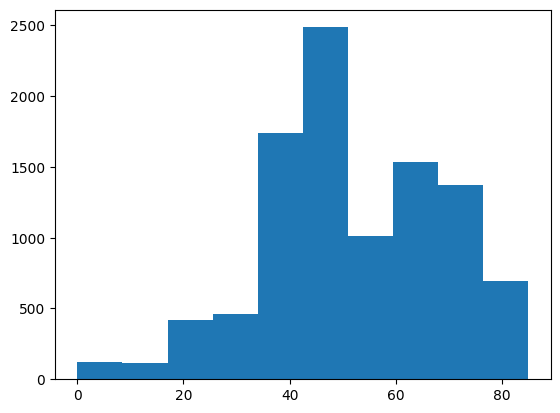

In [ ]:
plt.hist(df['age'])
plt.show()

In [ ]:
df['age'] = df['age'].fillna(df['age'].median())

In [ ]:
print(df.isnull().sum())

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [ ]:
print(df['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
def get_image_path(image_id):
    img_path = f"HAM10000_images_part_1/{image_id}.jpg"
    if not os.path.exists(img_path):
        img_path = f"HAM10000_images_part_2/{image_id}.jpg"
    return img_path

In [ ]:
df['image_path'] = df['image_id'].apply(get_image_path)

In [ ]:
categories = sorted(df['dx'].unique())
label_to_index = {label: index for index, label in enumerate(categories)}
index_to_label = {index: label for index, label in enumerate(categories)}
print("Categories:", categories)
print("Label to Index:", label_to_index)

Categories: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Label to Index: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Data Transformation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Add this
    transforms.RandomVerticalFlip(),    # Add this
    transforms.RandomRotation(degrees=(-20, 20)),  # Add this
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Add this
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class DermaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.metadata = df
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata.iloc[idx]['image_path']
        image = Image.open(img_path)
        label_str = self.metadata.iloc[idx]['dx']
        label_index = label_to_index[label_str]
        label = torch.tensor(label_index)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_dataset = DermaDataset(df, transform=None)
val_dataset = DermaDataset(df, transform=None)

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size


train_idx, val_idx, test_idx = random_split(range(len(train_dataset)), [train_size, val_size, test_size])

print(f"Length of initial_dataset: {len(train_dataset)}")
print(f"Length of train_idx: {len(train_idx)}")
print(f"Length of val_idx: {len(val_idx)}")
print(f"Length of test_idx: {len(test_idx)}")

Length of initial_dataset: 8012
Length of train_idx: 6409
Length of val_idx: 1603
Length of test_idx: 0


In [ ]:
train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)


In [ ]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


In [ ]:
weight = df
class_counts = weight['dx'].value_counts()

In [ ]:
class_weights = 1.0 / class_counts

In [ ]:
class_weights = class_weights / class_weights.sum()
class_weights

,count
dx,
nv,0.006570
mel,0.039582
bkl,0.040086
bcc,0.085709
akiec,0.134724
vasc,0.310244
df,0.383084


In [ ]:
sample_weights = weight['dx'].map(class_weights).values

In [ ]:
sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float)
sampler = WeightedRandomSampler(weights=sample_weights_tensor[train_idx],
                                num_samples=len(train_dataset),
                                replacement=True)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Visualize current data

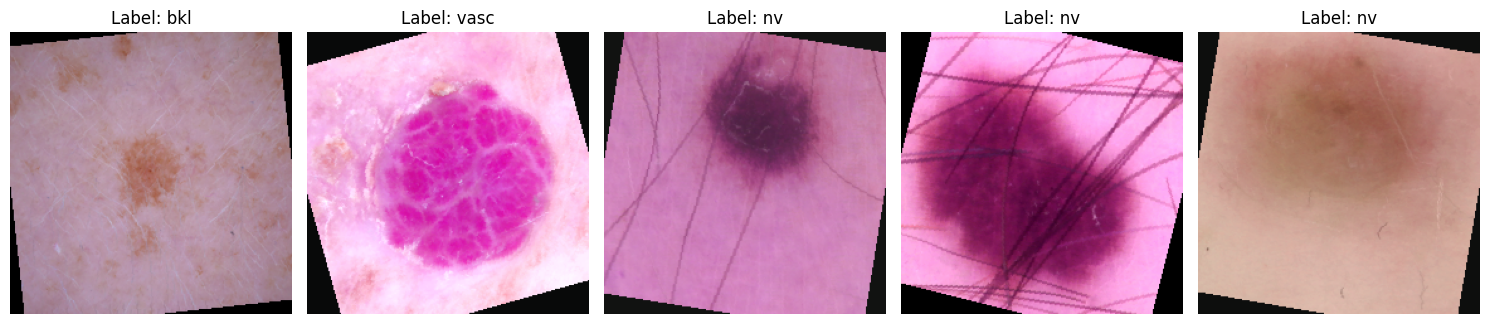

In [ ]:
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
train_dataset.transform = train_transform  # Ensure you apply transformations

for i in range(num_samples):
    image, label = train_dataset[i]  # Get a sample and its label
    image = image.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    image = image.numpy()  # Convert to numpy array for easier manipulation
    image = np.clip((image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]), 0, 1)  # Denormalize
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {categories[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Model and training setup => ResNet50


In [ ]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

number_features = model.fc.in_features
model.fc = nn.Linear(number_features, len(categories))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training Phase


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=25):
    since = time.time()
    early_stopping = EarlyStopping(patience=10, verbose=True)

    best_model = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [{phase}]", unit="batch") as pbar:
                for inputs, labels in pbar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += labels.size(0)

                    pbar.set_postfix({"loss": running_loss / total_samples, "acc": (running_corrects.double() / total_samples).item()})


            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                scheduler.step(epoch_loss)
                early_stopping(epoch_loss, model)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = model.state_dict()

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model)
    return model

In [ ]:
from tqdm import tqdm
num_epochs = 75
trained_model = train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=num_epochs)

Epoch 1/75
----------


Epoch 1/75 [train]: 100%|██████████| 251/251 [00:40<00:00,  6.15batch/s, loss=0.973, acc=0.656]


train Loss: 0.9728 Acc: 0.6564


Epoch 1/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.80batch/s, loss=0.669, acc=0.732]


val Loss: 0.6689 Acc: 0.7319
Validation loss decreased (inf --> 0.668853).  Saving model ...

Epoch 2/75
----------


Epoch 2/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.40batch/s, loss=0.508, acc=0.817]


train Loss: 0.5077 Acc: 0.8169


Epoch 2/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.78batch/s, loss=0.616, acc=0.79]


val Loss: 0.6156 Acc: 0.7903
Validation loss decreased (0.668853 --> 0.615602).  Saving model ...

Epoch 3/75
----------


Epoch 3/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.36batch/s, loss=0.378, acc=0.863]


train Loss: 0.3780 Acc: 0.8632


Epoch 3/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.95batch/s, loss=0.562, acc=0.778]


val Loss: 0.5616 Acc: 0.7778
Validation loss decreased (0.615602 --> 0.561590).  Saving model ...

Epoch 4/75
----------


Epoch 4/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.315, acc=0.882]


train Loss: 0.3155 Acc: 0.8818


Epoch 4/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.35batch/s, loss=0.508, acc=0.823]


val Loss: 0.5075 Acc: 0.8233
Validation loss decreased (0.561590 --> 0.507524).  Saving model ...

Epoch 5/75
----------


Epoch 5/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.33batch/s, loss=0.277, acc=0.899]


train Loss: 0.2770 Acc: 0.8994


Epoch 5/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.66batch/s, loss=0.472, acc=0.834]


val Loss: 0.4722 Acc: 0.8337
Validation loss decreased (0.507524 --> 0.472237).  Saving model ...

Epoch 6/75
----------


Epoch 6/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.252, acc=0.912]


train Loss: 0.2520 Acc: 0.9124


Epoch 6/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.95batch/s, loss=0.393, acc=0.859]


val Loss: 0.3934 Acc: 0.8587
Validation loss decreased (0.472237 --> 0.393443).  Saving model ...

Epoch 7/75
----------


Epoch 7/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.216, acc=0.926]


train Loss: 0.2160 Acc: 0.9264


Epoch 7/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.93batch/s, loss=0.51, acc=0.813]


val Loss: 0.5101 Acc: 0.8133
EarlyStopping counter: 1 out of 10

Epoch 8/75
----------


Epoch 8/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.201, acc=0.928]


train Loss: 0.2010 Acc: 0.9276


Epoch 8/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.80batch/s, loss=0.493, acc=0.817]


val Loss: 0.4928 Acc: 0.8173
EarlyStopping counter: 2 out of 10

Epoch 9/75
----------


Epoch 9/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.189, acc=0.931]


train Loss: 0.1888 Acc: 0.9306


Epoch 9/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 12.02batch/s, loss=0.379, acc=0.873]


val Loss: 0.3790 Acc: 0.8732
Validation loss decreased (0.393443 --> 0.378968).  Saving model ...

Epoch 10/75
----------


Epoch 10/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.172, acc=0.938]


train Loss: 0.1718 Acc: 0.9378


Epoch 10/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.87batch/s, loss=0.375, acc=0.875]


val Loss: 0.3753 Acc: 0.8747
Validation loss decreased (0.378968 --> 0.375323).  Saving model ...

Epoch 11/75
----------


Epoch 11/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.157, acc=0.942]


train Loss: 0.1567 Acc: 0.9422


Epoch 11/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.97batch/s, loss=0.445, acc=0.854]


val Loss: 0.4450 Acc: 0.8542
EarlyStopping counter: 1 out of 10

Epoch 12/75
----------


Epoch 12/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.14, acc=0.947]


train Loss: 0.1397 Acc: 0.9471


Epoch 12/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.89batch/s, loss=0.401, acc=0.867]


val Loss: 0.4014 Acc: 0.8672
EarlyStopping counter: 2 out of 10

Epoch 13/75
----------


Epoch 13/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.135, acc=0.951]


train Loss: 0.1355 Acc: 0.9513


Epoch 13/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.80batch/s, loss=0.443, acc=0.874]


val Loss: 0.4432 Acc: 0.8742
EarlyStopping counter: 3 out of 10

Epoch 14/75
----------


Epoch 14/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.119, acc=0.957]


train Loss: 0.1194 Acc: 0.9566


Epoch 14/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 12.09batch/s, loss=0.449, acc=0.865]


val Loss: 0.4489 Acc: 0.8647
EarlyStopping counter: 4 out of 10

Epoch 15/75
----------


Epoch 15/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.30batch/s, loss=0.115, acc=0.959]


train Loss: 0.1151 Acc: 0.9594


Epoch 15/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 12.16batch/s, loss=0.428, acc=0.874]


val Loss: 0.4280 Acc: 0.8737
EarlyStopping counter: 5 out of 10

Epoch 16/75
----------


Epoch 16/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.33batch/s, loss=0.112, acc=0.961]


train Loss: 0.1120 Acc: 0.9609


Epoch 16/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.80batch/s, loss=0.458, acc=0.865]


val Loss: 0.4580 Acc: 0.8652
EarlyStopping counter: 6 out of 10

Epoch 17/75
----------


Epoch 17/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.0847, acc=0.971]


train Loss: 0.0847 Acc: 0.9709


Epoch 17/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.92batch/s, loss=0.383, acc=0.883]


val Loss: 0.3830 Acc: 0.8832
EarlyStopping counter: 7 out of 10

Epoch 18/75
----------


Epoch 18/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.0609, acc=0.981]


train Loss: 0.0609 Acc: 0.9808


Epoch 18/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 12.08batch/s, loss=0.366, acc=0.897]


val Loss: 0.3657 Acc: 0.8967
Validation loss decreased (0.375323 --> 0.365725).  Saving model ...

Epoch 19/75
----------


Epoch 19/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.058, acc=0.982]


train Loss: 0.0580 Acc: 0.9817


Epoch 19/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.55batch/s, loss=0.375, acc=0.89]


val Loss: 0.3753 Acc: 0.8897
EarlyStopping counter: 1 out of 10

Epoch 20/75
----------


Epoch 20/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.0508, acc=0.984]


train Loss: 0.0508 Acc: 0.9838


Epoch 20/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.84batch/s, loss=0.377, acc=0.895]


val Loss: 0.3774 Acc: 0.8947
EarlyStopping counter: 2 out of 10

Epoch 21/75
----------


Epoch 21/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.0392, acc=0.988]


train Loss: 0.0392 Acc: 0.9876


Epoch 21/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 12.04batch/s, loss=0.363, acc=0.898]


val Loss: 0.3628 Acc: 0.8977
Validation loss decreased (0.365725 --> 0.362830).  Saving model ...

Epoch 22/75
----------


Epoch 22/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.0482, acc=0.984]


train Loss: 0.0482 Acc: 0.9844


Epoch 22/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.29batch/s, loss=0.37, acc=0.898]


val Loss: 0.3704 Acc: 0.8982
EarlyStopping counter: 1 out of 10

Epoch 23/75
----------


Epoch 23/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.0414, acc=0.986]


train Loss: 0.0414 Acc: 0.9863


Epoch 23/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.76batch/s, loss=0.384, acc=0.896]


val Loss: 0.3841 Acc: 0.8962
EarlyStopping counter: 2 out of 10

Epoch 24/75
----------


Epoch 24/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.0441, acc=0.986]


train Loss: 0.0441 Acc: 0.9856


Epoch 24/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.95batch/s, loss=0.377, acc=0.895]


val Loss: 0.3772 Acc: 0.8952
EarlyStopping counter: 3 out of 10

Epoch 25/75
----------


Epoch 25/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.0376, acc=0.988]


train Loss: 0.0376 Acc: 0.9875


Epoch 25/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.26batch/s, loss=0.387, acc=0.899]


val Loss: 0.3868 Acc: 0.8992
EarlyStopping counter: 4 out of 10

Epoch 26/75
----------


Epoch 26/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.33batch/s, loss=0.0366, acc=0.989]


train Loss: 0.0366 Acc: 0.9885


Epoch 26/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.74batch/s, loss=0.392, acc=0.903]


val Loss: 0.3923 Acc: 0.9026
EarlyStopping counter: 5 out of 10

Epoch 27/75
----------


Epoch 27/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.0313, acc=0.99]


train Loss: 0.0313 Acc: 0.9895


Epoch 27/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.99batch/s, loss=0.393, acc=0.899]


val Loss: 0.3934 Acc: 0.8987
EarlyStopping counter: 6 out of 10

Epoch 28/75
----------


Epoch 28/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.0355, acc=0.988]


train Loss: 0.0355 Acc: 0.9883


Epoch 28/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.97batch/s, loss=0.403, acc=0.899]


val Loss: 0.4026 Acc: 0.8987
EarlyStopping counter: 7 out of 10

Epoch 29/75
----------


Epoch 29/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.31batch/s, loss=0.0334, acc=0.989]


train Loss: 0.0334 Acc: 0.9890


Epoch 29/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.92batch/s, loss=0.39, acc=0.899]


val Loss: 0.3901 Acc: 0.8987
EarlyStopping counter: 8 out of 10

Epoch 30/75
----------


Epoch 30/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.30batch/s, loss=0.036, acc=0.988]


train Loss: 0.0360 Acc: 0.9879


Epoch 30/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 12.01batch/s, loss=0.391, acc=0.893]


val Loss: 0.3908 Acc: 0.8932
EarlyStopping counter: 9 out of 10

Epoch 31/75
----------


Epoch 31/75 [train]: 100%|██████████| 251/251 [00:39<00:00,  6.32batch/s, loss=0.0382, acc=0.987]


train Loss: 0.0382 Acc: 0.9866


Epoch 31/75 [val]: 100%|██████████| 63/63 [00:05<00:00, 11.93batch/s, loss=0.389, acc=0.896]

val Loss: 0.3889 Acc: 0.8957
EarlyStopping counter: 10 out of 10
Early stopping
Training complete in 23m 20s
Best val Acc: 0.902646


In [ ]:
torch.save(trained_model.state_dict(), 'model_skin.pth')


## Evaluate

<ipython-input-41-a6a9a1fec4c9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_skin.pth", map_location=device))  # Load best weight

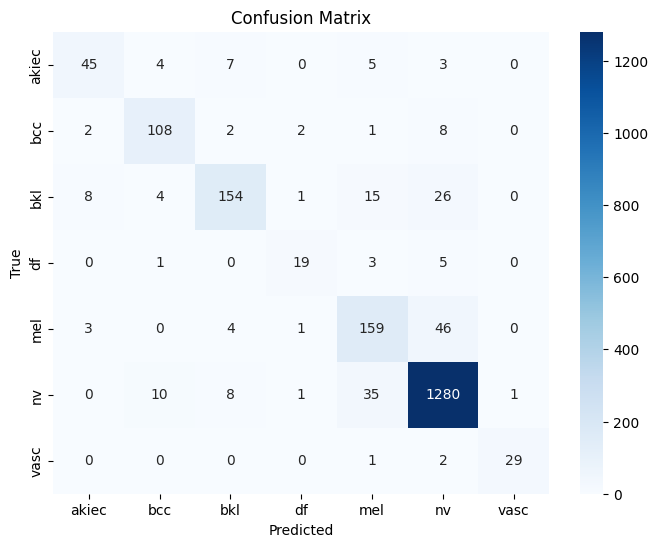

Overall Accuracy: 0.8957

Classification Report:
              precision    recall  f1-score   support

       akiec       0.78      0.70      0.74        64
         bcc       0.85      0.88      0.86       123
         bkl       0.88      0.74      0.80       208
          df       0.79      0.68      0.73        28
         mel       0.73      0.75      0.74       213
          nv       0.93      0.96      0.95      1335
        vasc       0.97      0.91      0.94        32

    accuracy                           0.90      2003
   macro avg       0.85      0.80      0.82      2003
weighted avg       0.89      0.90      0.89      2003



In [ ]:
model.load_state_dict(torch.load("model_skin.pth", map_location=device))  # Load best weights
model.eval()

def evaluate_model(model, dataloader, categories):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted class indices

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # --- Overall Accuracy ---
    accuracy = (true_labels == predicted_labels).mean()
    print(f'Overall Accuracy: {accuracy:.4f}')

    # --- Classification Report (Precision, Recall, F1-score) ---
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=categories))

evaluate_model(model, val_dataloader, categories)